In [1]:
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import pickle
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from typing import List, Tuple, Dict

# Common Variables

In [2]:
DATA_CACHE = Path('../data/cache/')
DATA_RAW = Path('../data/raw/')

EEG_PATH = DATA_RAW / 'train_eegs/'
SPEC_PATH = DATA_RAW / 'train_spectrograms/'

EEG_SAMPLE_RATE = 200           # Hz
SPEC_SAMPLE_RATE = 0.5          # Hz
EEG_SNIPPET_LEN = 50            # seconds
SPECTROGRAM_SNIPPET_LEN = 600   # seconds


# check if global variables are defined
if '_eegs_raw' not in globals():
    _eegs_raw = None

if '_metadata' not in globals():
    _metadata = None

if '_spectrograms_raw' not in globals():
    _spectrograms_raw = None

# Dataset Utils

In [3]:
def get_egg_data(use_cache=True):
    global _eegs_raw
    
    if _eegs_raw is not None:
        return _eegs_raw
    
    if use_cache and os.path.exists(DATA_CACHE / 'eegs_raw.pkl'):
        print('Loading EEG data from pickle file')
        _eegs_raw = pickle.load(open(DATA_CACHE / 'eegs_raw.pkl', 'rb'))
        return _eegs_raw
    
    print('Loading EEG data from parquet files')
    metadata = get_metadata()
    _eegs_raw = {}
    for eeg_id in tqdm(metadata.eeg_id.unique()):
        _eegs_raw[eeg_id] = pd.read_parquet(f'{EEG_PATH}/{eeg_id}.parquet')

    if use_cache:
        print('Saving eegs_raw to pickle file')
        if not os.path.exists(DATA_CACHE):
            os.makedirs(DATA_CACHE)
        with open(DATA_CACHE / 'eegs_raw.pkl', 'wb') as f:
            pickle.dump(_eegs_raw, f)

    return _eegs_raw

def get_full_eeg_by_id(eeg_id):
    return get_egg_data()[eeg_id]

def get_full_eeg_by_id_single(eeg_id):
    return pd.read_parquet(f'{EEG_PATH}/{eeg_id}.parquet')

def get_full_eeg_by_id_single(eeg_id):
    return pd.read_parquet(f'{EEG_PATH}/{eeg_id}.parquet')

def get_snippet_eeg_by_id(eeg_id, eeg_center: float, duration: float = 50):
    eeg = get_egg_data()[eeg_id]
    eeg = eeg.iloc[
        round((eeg_center-duration/2)*EEG_SAMPLE_RATE):
        round((eeg_center+duration/2)*EEG_SAMPLE_RATE)]
    return eeg

def get_spectrogram_data(use_cache=True):
    global _spectrograms_raw
    
    if _spectrograms_raw is not None:
        return _spectrograms_raw
    
    if use_cache and os.path.exists(DATA_CACHE / 'spectrograms_raw.pkl'):
        print('Loading spectrogram data from pickle file')
        _spectrograms_raw = pickle.load(open(DATA_CACHE / 'spectrograms_raw.pkl', 'rb'))
        return _spectrograms_raw
    
    print('Loading spectrogram data from parquet files')
    metadata = get_metadata()
    _spectrograms_raw = {}
    for spectrogram_id in tqdm(metadata.spectrogram_id.unique()):
        data = pd.read_parquet(f'{SPEC_PATH}/{spectrogram_id}.parquet')

        LL = data.filter(regex='^LL')
        LP = data.filter(regex='^LP')
        RP = data.filter(regex='^RP')
        RL = data.filter(regex='^RL')
        _spectrograms_raw[spectrogram_id] = torch.stack([
            torch.tensor(LL.values).T,
            torch.tensor(LP.values).T,
            torch.tensor(RP.values).T,
            torch.tensor(RL.values).T
        ])

    if use_cache:
        print('Saving spectrograms to pickle file')
        if not os.path.exists(DATA_CACHE):
            os.makedirs(DATA_CACHE)
        with open(DATA_CACHE / 'spectrograms_raw.pkl', 'wb') as f:
            pickle.dump(_spectrograms_raw, f)

    return _spectrograms_raw

def get_full_spectrogram_by_id(spectrogram_id) -> Dict[str, pd.DataFrame]:
    return get_spectrogram_data()[spectrogram_id]
    
def get_snippet_spectrogram_by_id(spectrogram_id: int, spectrogram_center: float = 300, duration: float = 600):    
    spectrogram = get_spectrogram_data()[spectrogram_id]
    spectrogram = spectrogram[:, :,
        round((spectrogram_center-duration/2)*SPEC_SAMPLE_RATE):
        round((spectrogram_center+duration/2)*SPEC_SAMPLE_RATE)]
    return spectrogram


def get_metadata():
    global _metadata

    if _metadata is not None:
        return _metadata
    
    print('Loading metadata from parquet file')
    _metadata = pd.read_csv(DATA_RAW / 'train.csv')

    # Add 'center' columns for spectrogram and eeg
    _metadata['eeg_center'] = _metadata.eeg_label_offset_seconds + EEG_SNIPPET_LEN/2
    _metadata['spectrogram_center'] = _metadata.spectrogram_label_offset_seconds + SPECTROGRAM_SNIPPET_LEN/2

    return _metadata

def get_data(row, eeg_duration=50, spec_duration=50):
    eeg = get_snippet_eeg_by_id(row.eeg_id, row.eeg_center, duration=eeg_duration)
    spectrogram = get_snippet_spectrogram_by_id(row.spectrogram_id, row.spectrogram_center, duration=spec_duration)
    return eeg, spectrogram

def convert_to_spectrogram_id(eeg_id):
    metadata = get_metadata()
    metadata = metadata[metadata.eeg_id == eeg_id]
    return metadata.spectrogram_id.values[0]

# Visualization Utils

In [4]:
def visualize_eeg(signal):
    plt.figure(figsize=(10, 5))
    plt.plot(signal)
    plt.title('EEG')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

def visualize_spectrogram(spectrogram: torch.Tensor, time=50, freq=40):
    plt.figure(figsize=(10, 5))
    plt.imshow(spectrogram, aspect='auto', origin='lower', extent=[0, spectrogram.shape[1], 0, spectrogram.shape[0]])
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Frequency')
    plt.ylabel('Time')
    plt.show()

def visualize_spectrograms(spectrograms: torch.Tensor, time_start = 0, sample_rate = SPEC_SAMPLE_RATE, freq=40):
    n = len(spectrograms)

    fig, axs = plt.subplots(1, n, figsize=(5*n, 5))
    for i in range(n):
        axs[i].imshow(spectrograms[i], aspect='auto', origin='lower', extent=[time_start, time_start+spectrograms.shape[2]/sample_rate, 0, spectrograms.shape[1]])
        axs[i].set_title(f'Channel {i}')
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('Frequency')
    plt.show()


# Test on Synthetic Data

Creating EEG Spectrograms: 100%|██████████| 1/1 [00:00<00:00, 51.11it/s]


torch.Size([128, 313])
Before:  torch.Size([4, 128, 313])
Space left:  3 Space right:  4
After:  torch.Size([4, 128, 320])
torch.Size([4, 128, 320])
tensor([0.0000, 0.0000, 0.0000, 1.4103, 1.6148]) tensor([3.1749, 0.0000, 0.0000, 0.0000, 0.0000])
tensor([0.0000, 0.0000, 0.0000, 1.3926, 1.6233]) tensor([3.1775, 0.0000, 0.0000, 0.0000, 0.0000])
tensor([0.0000, 0.0000, 0.0000, 1.2861, 1.5713]) tensor([3.1138, 0.0000, 0.0000, 0.0000, 0.0000])
tensor([0.0000, 0.0000, 0.0000, 1.1697, 1.5439]) tensor([3.0694, 0.0000, 0.0000, 0.0000, 0.0000])


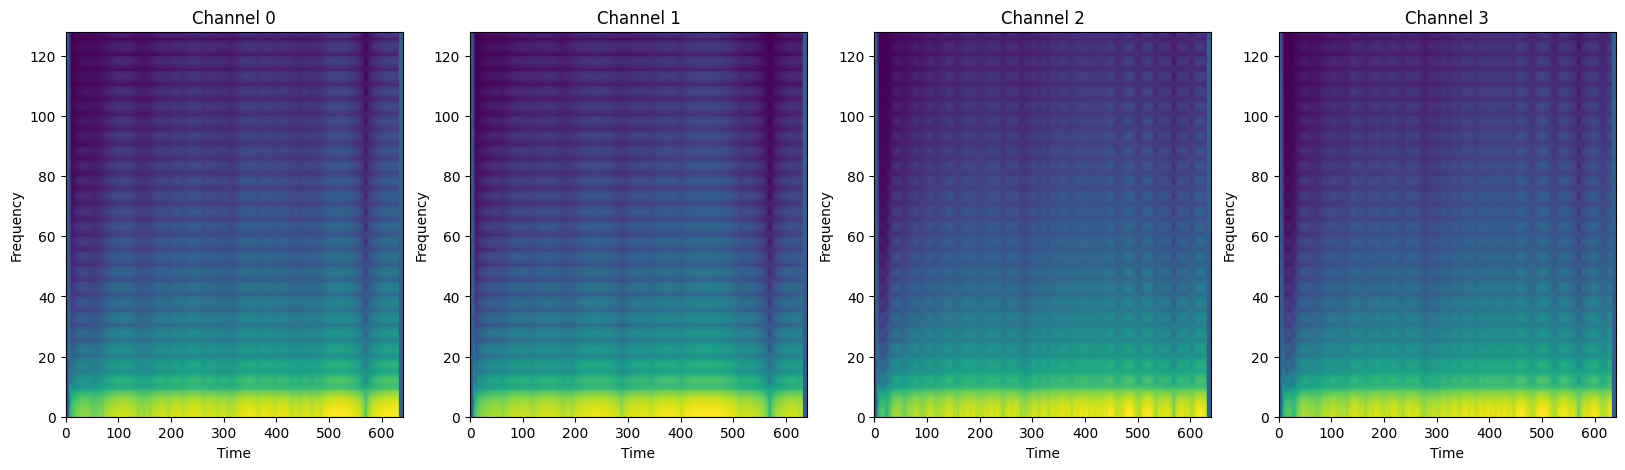

In [5]:
import torch
import pandas as pd
import sys
sys.path.insert(1, '../')

from src.typing.typing import XData
from src.modules.transformation.spectrogram.eeg_to_spectrogram import EEGToSpectrogram

EEG_SAMPLE_RATE = 200
EEG_SNIPPET_LEN = 50

def create_test_eeg():
    num_steps = 18000  # Number of steps per signal
    num_signals = 20   # Number of different signals
    time_steps = torch.arange(0, num_steps) / num_steps  # Normalized time steps [0, 1]

    signals = torch.zeros((num_steps, num_signals))
    for i in range(num_signals):
        signals[:, i] = torch.sin(2 * np.pi * i * time_steps)
    signals_array = signals.numpy()

    column_names = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']
    signals_df = pd.DataFrame(data=signals_array, columns=column_names)
    return signals_df

data = XData(None, None, None, None, None)
data.eeg = {1: create_test_eeg()}
data.shared = {'eeg_freq': EEG_SAMPLE_RATE}

spec_tran_instance = EEGToSpectrogram()
spec_tran_instance.fitting_method = 'pad'
data = spec_tran_instance.custom_transform(data)

print(data.shared['eeg_spec_test_spectrogram_size'])

# Save the created spectrogram to disk (for unit testing)
torch.save(data.eeg_spec[1], 'test_eeg_spec.pt')

#
# Create batch (only eeg spectrograms) - assume offset is 0 for all
#

def convert(offset, eeg_shape, eeg_spec_shape):
    return int((offset * eeg_spec_shape[2]) / eeg_shape[0])

batch = {}
for eeg_id in [1]:
    offset = 0
    set_spec_size = spec_tran_instance.size
    set_fitting_method = spec_tran_instance.fitting_method

    start = convert(offset * EEG_SAMPLE_RATE, data.eeg[eeg_id].shape, data.eeg_spec[eeg_id].shape)
    end = convert((offset + EEG_SNIPPET_LEN) * EEG_SAMPLE_RATE, 
                  data.eeg[eeg_id].shape, 
                  data.eeg_spec[eeg_id].shape)
    
    # Make sure that the training spectrograms are the same size as the test spectrograms
    difference = (end - start) - data.shared['eeg_spec_test_spectrogram_size'][1]
    end -= difference
    batch[eeg_id] = data.eeg_spec[eeg_id][:, :, start:end]

    print('Before: ',batch[eeg_id].shape)

    space_left = abs(batch[eeg_id].shape[2] - set_spec_size[1]) // 2
    space_right = abs(batch[eeg_id].shape[2] - set_spec_size[1]) - space_left
    print('Space left: ', space_left, 'Space right: ', space_right)

    if set_fitting_method == 'pad':
        batch[eeg_id] = torch.nn.functional.pad(batch[eeg_id], (space_left, space_right))
    elif set_fitting_method == 'crop':
        batch[eeg_id] = batch[eeg_id][:, :, space_left:-space_right]

    print('After: ',batch[eeg_id].shape)

for eeg_id in [1]:
    print(batch[eeg_id].shape)
    # Print the first 4 and last 4 values of the first channel/row
    for i in range(4):
        print(batch[eeg_id][0, i, :5], batch[eeg_id][0, i, -5:])
    visualize_spectrograms(batch[eeg_id])


# Test on Real Data

In [6]:
import torch
import pandas as pd
import sys
sys.path.insert(1, '../')

from src.typing.typing import XData
from src.modules.transformation.spectrogram.eeg_to_spectrogram import EEGToSpectrogram

EEG_SAMPLE_RATE = 200
EEG_SNIPPET_LEN = 50

data = XData(None, None, None, None, None)
# data.eeg = {1457334423: get_full_eeg_by_id_single(1457334423)}
data.eeg = get_egg_data()
data.shared = {'eeg_freq': EEG_SAMPLE_RATE}

# Check all eegs for NaN values, set them to 0 if found
# EEGs are pandas dataframes
count = 0
for eeg_id in data.eeg:
    if data.eeg[eeg_id].isnull().values.any():
        data.eeg[eeg_id] = data.eeg[eeg_id].fillna(0)
        count += 1
print('Number of eegs with NaN values:', count)

count = 0
for eeg_id in data.eeg:
    if data.eeg[eeg_id].isnull().values.any():
        data.eeg[eeg_id] = data.eeg[eeg_id].fillna(0)
        count += 1
print('Number of eegs with NaN values after clean:', count)


spec_tran_instance = EEGToSpectrogram()
spec_tran_instance.fitting_method = 'pad'
data = spec_tran_instance.custom_transform(data)

# Check all spectrograms for NaN values
count = 0
for eeg_id in data.eeg_spec:
    if torch.isnan(data.eeg_spec[eeg_id]).any():
        count += 1
print('Number of spectrograms with NaN values:', count)


Loading EEG data from pickle file
Number of eegs with NaN values: 824
Number of eegs with NaN values after clean: 0


Creating EEG Spectrograms: 100%|██████████| 17089/17089 [03:52<00:00, 73.45it/s]


Number of spectrograms with NaN values: 0
